<a href="https://colab.research.google.com/github/sfwtopoulos/stocks/blob/master/Stocks_seq_1st.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import math
import warnings
import numpy as np
import time

import pandas_datareader as pdr
#%tensorflow_version 2.x
# Restart runtime using 'Runtime' -> 'Restart runtime...'
%tensorflow_version 1.x
import tensorflow as tf
import keras


from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout
from keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [16]:
print(keras.__version__)
print(tf.__version__)
#print(tensorflow.compat.v2.__version__)

2.2.5
1.15.0


In [0]:
#Data import from git repo
url = 'https://raw.githubusercontent.com/sfwtopoulos/stocks/master/stocks_dataset/combined.csv'
#df1 = pd.read_csv(url, error_bad_lines=False)
dfstocks = pd.read_csv(url, sep=',')

In [18]:
#fix column names
dfstocks=dfstocks.rename({' AAPL':'Company', ' Close/Last':'Close', ' Volume':'Volume', ' Open':'Open', ' High':'High', ' Low':'Low'}, axis=1);
for col in dfstocks.columns: 
    print(col) 

Date
Close
Volume
Open
High
Low
Company


In [0]:
#drop $sign from values
dfstocks.Close=dfstocks['Close'].astype(str)
dfstocks.Close=dfstocks.Close.apply(lambda x: x.replace('$',''))
dfstocks.Open=dfstocks['Open'].astype(str)
dfstocks.Open=dfstocks.Open.apply(lambda x: x.replace('$',''))
dfstocks.High=dfstocks['High'].astype(str)
dfstocks.High=dfstocks.High.apply(lambda x: x.replace('$',''))
dfstocks.Low=dfstocks['Low'].astype(str)
dfstocks.Low=dfstocks.Low.apply(lambda x: x.replace('$',''))

In [20]:
#drop rows containing nan or header from the csv files
dfstocks=dfstocks[~dfstocks.Low.str.contains("nan")]
dfstocks=dfstocks[~dfstocks.Low.str.contains("Low")]
dfstocks=dfstocks[~dfstocks.Low.str.contains("N/A")]
dfstocks=dfstocks[~dfstocks.Volume.str.contains("N/A")]
dfstocks.reset_index(drop=True, inplace=True)
dfstocks.Date.count()

229269

In [21]:
#sort dataframe based on date and Company Name
dfstocks = dfstocks.sort_values(['Date', 'Company'])
dfstocks.head(100)

,Date,Close,Volume,Open,High,Low,Company
1761,01/02/2013,78.4328,139906732,79.1171,79.2857,77.3757,AAPL
4248,01/02/2013,35.12,13767660,34.92,35.4,34.1,ABBV
6025,01/02/2013,32.05,20266410,32.3,32.45,31.64,ABT
8512,01/02/2013,69.06,4039095,67.59,69.06,67.55,ACN
10999,01/02/2013,38.34,6483720,37.92,38.73,37.92,ADBE
...,...,...,...,...,...,...,...
10747,01/02/2014,59.29,2745895,59.06,59.53,58.94,ADBE
13234,01/02/2014,168.05,1268722,167.33,170.71,166.5937,AGN
15721,01/02/2014,50.71,9196092,50.81,51.3,50.47,AIG
18208,01/02/2014,53.55,1909106,54.09,54.45,53.5,ALL


In [22]:
#Converting Datatypes
dfstocks.Date=pd.to_datetime(dfstocks.Date)
dfstocks.Close=pd.to_numeric(dfstocks.Close)
dfstocks.Volume=pd.to_numeric(dfstocks.Volume)
dfstocks.Open=pd.to_numeric(dfstocks.Open)
dfstocks.High=pd.to_numeric(dfstocks.High)
dfstocks.Low=pd.to_numeric(dfstocks.Low)
dfstocks.dtypes

Date       datetime64[ns]
Close             float64
Volume              int64
Open              float64
High              float64
Low               float64
Company            object
dtype: object

In [23]:
#dfstocks[dfstocks['Company'].str.contains("AMZN")]
sub_split=dfstocks[dfstocks['Company'].str.contains("AIG")]
sub_split.isnull().values.any()
sub_split.isna().values.any()
sub_split = sub_split.sort_values(['Date'])
sub_split.reset_index(drop=True, inplace=True)
sub_split.shape[0]

2487

In [24]:
sub_split

,Date,Close,Volume,Open,High,Low,Company
0,2010-02-16,24.2741,6885337,24.2741,24.6812,23.9378,AIG
1,2010-02-17,23.8051,5359506,24.3626,24.6369,23.5927,AIG
2,2010-02-18,23.6369,6479876,23.3715,24.3537,23.2299,AIG
3,2010-02-19,23.4776,4670052,23.4865,23.7431,23.3095,AIG
4,2010-02-22,25.1590,24127010,23.7962,25.9290,23.5130,AIG
...,...,...,...,...,...,...,...
2482,2019-12-24,50.9400,1138631,50.7900,51.4500,50.7872,AIG
2483,2019-12-26,50.6200,2811077,51.0500,51.1900,50.5723,AIG
2484,2019-12-27,51.0700,2374830,50.7600,51.0800,50.5800,AIG
2485,2019-12-30,51.0000,2706309,51.2200,51.2300,50.7800,AIG


In [0]:
# prepare training and testing data sets for LSTM based sequence modeling
#def dimitris_function(time_series, scaling=True,split_ratio=0.9):
def dimitris_function(time_series,split_ratio=0.9):

    series1 = pd.Series(time_series[time_series.columns[0]])
    series2 = pd.Series(time_series[time_series.columns[1]])

    values1 = series1.values
    values1 = values1.reshape((len(values1), 1))
    values2 = series2.values
    values2 = values2.reshape((len(values2), 1))

    scaler1 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled1"] = scaler1.fit_transform(values1)
    scaler2 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled2"]= scaler2.fit_transform(values2)


    time_series = time_series[["scaled1","scaled2"]].values

        
    split_ratio = int(len(time_series) * split_ratio)

    train = time_series[0:split_ratio]
    test = time_series[split_ratio:len(time_series)]
    
    # return train,test,scaler1,scaler2
    return train,test,scaler2


In [0]:
def get_seq_model(hidden_units=4,input_shape=(1,1)):
    # create and fit the LSTM network
    model = Sequential()
    # samples*timesteps*features
    # https://keras.io/getting-started/sequential-model-guide/
    #relu_advanced=keras.activations.relu(x,)
    model.add(LSTM(input_shape=input_shape,
                   units = hidden_units,  
   #                activation='relu',
                   return_sequences=True
    ))

    # readout layer. TimeDistributedDense uses the same weights for all
    # time steps.
    # model.add(TimeDistributed(Dense(1))) #number of inputs in the 1st layer
    model.add(TimeDistributed(Dense(2)))   
    start = time.time()
    
    model.compile(loss="mse", optimizer="rmsprop")

    print("> Compilation Time : ", time.time() - start)
    print(model.summary())

    return model

In [0]:
# print(type(sub_split.Close))
sub_split_date=sub_split[['Date']]
sub_split=sub_split[['Volume', 'Close']]
#sub_split.columns[1]

In [0]:
# split train and test datasets
train,test,scaler_Close = dimitris_function(sub_split,split_ratio=0.7)

#train
print(len(train))
print(train.shape[0])
print(train.shape)
print(test.shape)
print(train)

In [30]:
#We use numpy to reshape our time series into 3D tensors.
train = np.reshape(train,(1,train.shape[0],2))
test = np.reshape(test,(1,test.shape[0],2))

train_x = train[:,:-1,:]
train_y = train[:,1:,:]

test_x = test[:,:-1,:]
test_y = test[:,1:,:]

print("Data Split Complete")

print("train_x shape={}".format(train_x.shape))
print("train_y shape={}".format(train_y.shape))
print("test_x shape={}".format(test_x.shape))
print("test_y shape={}".format(test_y.shape))

Data Split Complete
train_x shape=(1, 1739, 2)
train_y shape=(1, 1739, 2)
test_x shape=(1, 746, 2)
test_y shape=(1, 746, 2)


In [31]:
# build RNN model
seq_lstm_model=None
try:
    seq_lstm_model = get_seq_model(input_shape=(train_x.shape[1],2))
except:
    print("Model Build Failed. Trying Again")
    seq_lstm_model = get_seq_model(input_shape=(train_x.shape[1],2))





> Compilation Time :  0.024010658264160156
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1739, 4)           112       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1739, 2)           10        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
train_y

array([[[0.01377032, 0.07925101],
        [0.01725527, 0.07568216],
        [0.01162576, 0.07230214],
        ...,
        [0.01061443, 0.98260132],
        [0.01250318, 1.        ],
        [0.01188957, 0.99469552]]])

In [0]:
# train the model
seq_lstm_model.fit(train_x, train_y,
                #epochs=20, batch_size=1,
                epochs=250, batch_size=1,
                verbose=2)
print("Model Fit Complete")

In [34]:
# train fit performance
trainPredict = seq_lstm_model.predict(train_x)
trainScore = math.sqrt(mean_squared_error(train_y[0], trainPredict[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.04 RMSE


In [35]:
trainPredict

array([[[0.00524259, 0.05629676],
        [0.01239465, 0.06648792],
        [0.01866769, 0.07319361],
        ...,
        [0.01453967, 0.95184344],
        [0.01406205, 0.95321697],
        [0.01314679, 0.9550026 ]]], dtype=float32)

In [0]:
# Pad input sequence
testPredict = pad_sequences(test_x,maxlen=train_x.shape[1],padding='post',dtype='float64')

In [37]:
# forecast values
testPredict = seq_lstm_model.predict(testPredict)
testPredict

array([[[-0.02853483,  0.22535498],
        [-0.04475883,  0.3774362 ],
        [-0.05084489,  0.4975566 ],
        ...,
        [ 0.04373723,  0.01307033],
        [ 0.04373723,  0.01307033],
        [ 0.04373723,  0.01307033]]], dtype=float32)

In [38]:
# forecast values
testPredict = seq_lstm_model.predict(testPredict)
testPredict

array([[[-0.00401917,  0.08016212],
        [-0.01051989,  0.14314704],
        [-0.01881668,  0.21758394],
        ...,
        [ 0.04879891,  0.02734985],
        [ 0.04879891,  0.02734985],
        [ 0.04879891,  0.02734985]]], dtype=float32)

In [39]:
testPredict

array([[[-0.00401917,  0.08016212],
        [-0.01051989,  0.14314704],
        [-0.01881668,  0.21758394],
        ...,
        [ 0.04879891,  0.02734985],
        [ 0.04879891,  0.02734985],
        [ 0.04879891,  0.02734985]]], dtype=float32)

In [0]:
#Drop all other variables except Close Price Output
testPredict=np.delete(testPredict, 0, 2)
trainPredict=np.delete(trainPredict, 0, 2)

In [41]:
trainPredict


array([[[0.05629676],
        [0.06648792],
        [0.07319361],
        ...,
        [0.95184344],
        [0.95321697],
        [0.9550026 ]]], dtype=float32)

In [42]:
type(testPredict)

numpy.ndarray

In [0]:
# # inverse transformation of the Close Price
trainPredict = scaler_Close.inverse_transform(trainPredict.\
                                        reshape(-1,1))
testPredict = scaler_Close.inverse_transform(testPredict.\
                                       reshape(-1,1))

In [44]:
trainPredict

array([[22.723267],
       [23.203575],
       [23.519615],
       ...,
       [64.93038 ],
       [64.99512 ],
       [65.07927 ]], dtype=float32)

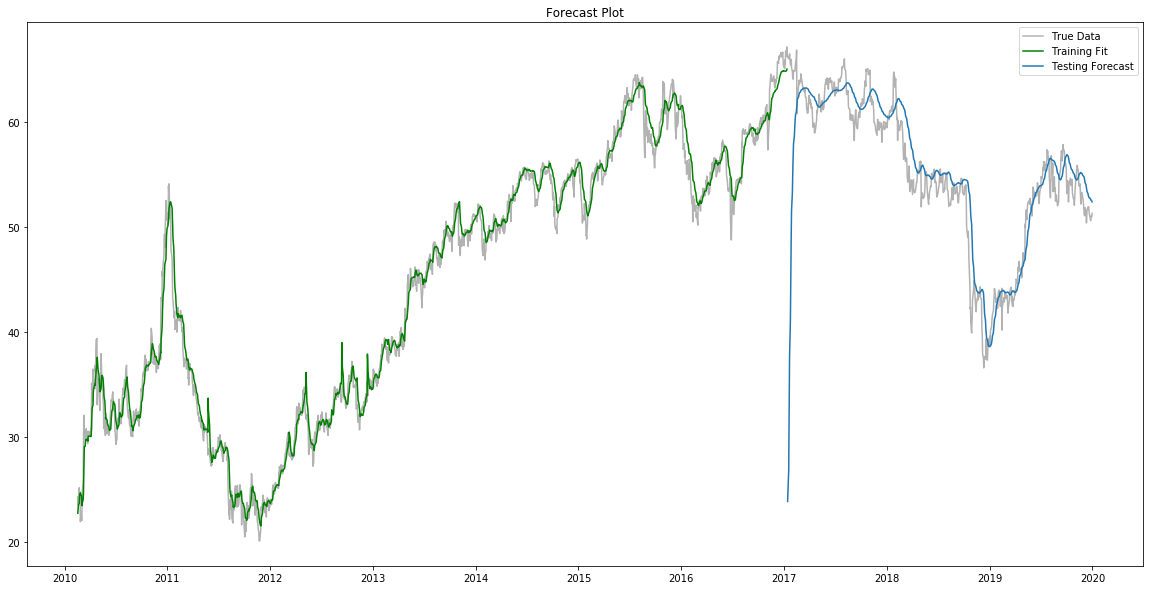

In [48]:
# plot the true and forecasted values
split_ratio = len(trainPredict)+1

plt.plot(sub_split_date.Date,
          sub_split.Close.values,c='black',
          alpha=0.3,label='True Data')

plt.plot(sub_split_date.Date[1:split_ratio],
          trainPredict,label='Training Fit',c='g')

plt.plot(sub_split_date.Date[split_ratio+1:],
          testPredict[:test_x.shape[1]],label='Testing Forecast')
plt.title('Forecast Plot')
plt.legend()
#plt.show()
plt.rcParams["figure.figsize"] = (20,10)
plt.show()